# Python solving with LeNet

In this example, we'll explore learning with Caffe in Python, using the fully-exposed `Solver` interface.

In [1]:
import os
os.chdir('..')

In [2]:
import sys
sys.path.insert(0, './python')
import caffe

from pylab import *
%matplotlib inline

We'll be running the provided LeNet example (make sure you've downloaded the data and created the databases, as below).

In [3]:
!data/mnist/get_mnist.sh
!examples/mnist/create_mnist.sh

Downloading...
--2015-03-12 11:54:02--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com... 128.122.47.89
Connecting to yann.lecun.com|128.122.47.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: 'train-images-idx3-ubyte.gz'

train-images-idx3-u 100%[=====================>]   9.45M   194KB/s   in 51s    

2015-03-12 11:54:54 (188 KB/s) - 'train-images-idx3-ubyte.gz' saved [9912422/9912422]

--2015-03-12 11:54:54--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com... 128.122.47.89
Connecting to yann.lecun.com|128.122.47.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: 'train-labels-idx1-ubyte.gz'

train-labels-idx1-u 100%[=====================>]  28.20K   104KB/s   in 0.3s   

2015-03-12 11:54:55 (104 KB/s) - 'train-labels-idx1-ubyte.gz' saved [28881/28881]

--2015-03-12 11:

We need two external files to help out:
* the solver prototxt, defining the learning parameters
* the net prototxt, defining the architecture and train/test data

Here are the learning parameters.

In [7]:
!cat examples/mnist/lenet_solver.prototxt

# The train/test net protocol buffer definition
net: "examples/mnist/lenet_train_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "examples/mnist/lenet"
# solver mode: CPU or GPU
solver_mode: GPU


And here is the version of LeNet we'll be using. In future version of Caffe, networks can be defined directly in Python (see [PR #2086](https://github.com/BVLC/caffe/pull/2086)).

This network expects to read from pregenerated LMDBs, but reading directly from `ndarray`s is also possible using `MemoryDataLayer`.

In [8]:
!cat examples/mnist/lenet_train_test.prototxt

name: "LeNet"
layer {
  name: "mnist"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "examples/mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "mnist"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "examples/mnist/mnist_test_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  convolution_param {
    num_output: 20
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  typ

Let's pick a device and load the solver. We'll use SGD (with momentum), but Adagrad and Nesterov's accelerated gradient are also available.

In [9]:
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/mnist/lenet_solver.prototxt')

To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

In [10]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('ip1', (64, 500)),
 ('ip2', (64, 10)),
 ('loss', ())]

In [11]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('ip1', (500, 800)),
 ('ip2', (10, 500))]

Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

In [12]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'accuracy': array(0.07000000029802322, dtype=float32),
 'loss': array(2.375746726989746, dtype=float32)}

[ 5.  0.  4.  1.  9.  2.  1.  3.]


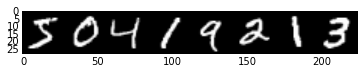

In [13]:
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
print solver.net.blobs['label'].data[:8]

[ 7.  2.  1.  0.  4.  1.  4.  9.]


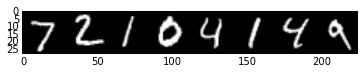

In [14]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
print solver.test_nets[0].blobs['label'].data[:8]

Both train and test nets seem to be loading data, and to have correct labels.

Let's take one step of (minibatch) SGD and see what happens.

In [15]:
solver.step(1)

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

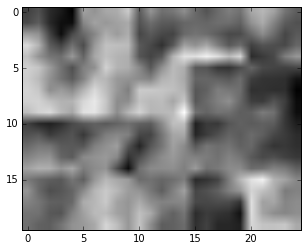

In [16]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

In [17]:
%%time
niter = 200
# losses will also be stored in the log
train_loss = zeros(niter)
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]

CPU times: user 13 s, sys: 134 ms, total: 13.1 s
Wall time: 13 s


Let's plot the train loss. (Normally we should plot the test loss as well, but we're only testing every 500 iterations, and loss drops very quickly for this example.)

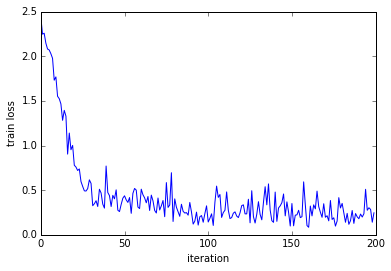

In [18]:
plot(arange(niter), train_loss)
xlabel('iteration')
ylabel('train loss')

It seems to have dropped quickly and coverged (except for stochasticity); hooray!

Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the $x$ axis and each possible label on the $y$, with lightness indicating confidence.

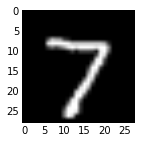

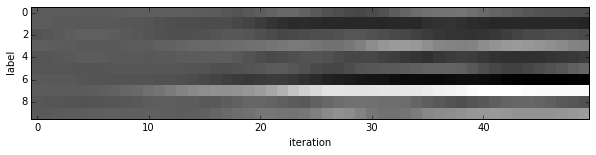

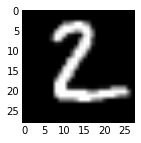

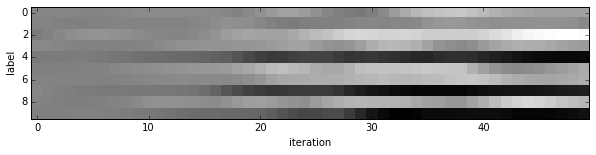

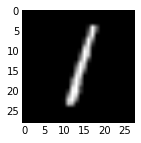

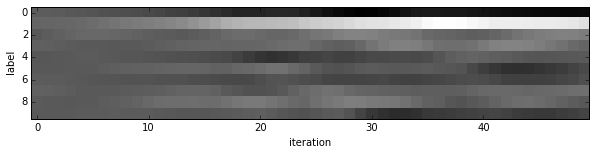

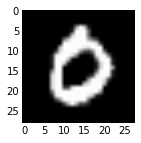

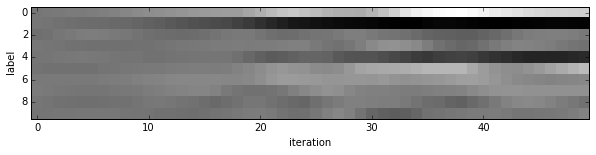

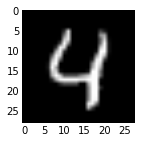

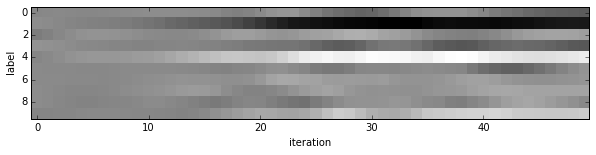

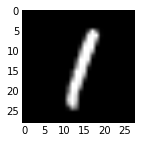

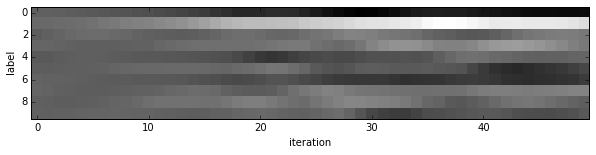

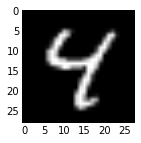

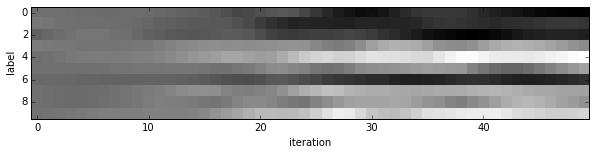

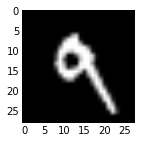

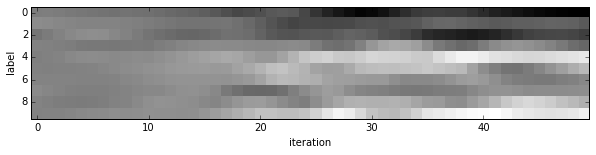

In [19]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

We started with little idea about any of these digits, and ended up with correct classifications for each. If you've been following along, you'll see the last digit is the most difficult, a slanted "9" that's (understandably) most confused with "4".

Note that these are the "raw" output scores rather than the softmax-computed probability vectors. The latter, shown below, make it easier to see the confidence of our net (but harder to see the scores for less likely digits).

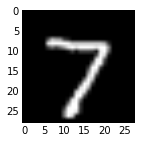

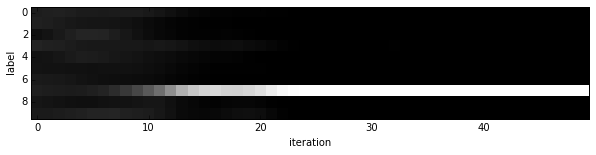

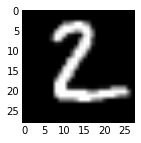

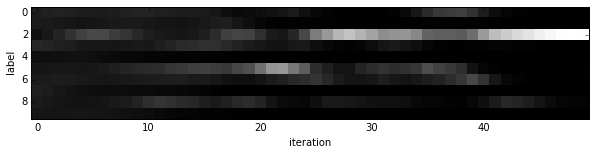

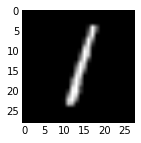

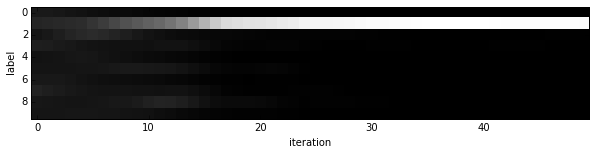

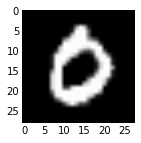

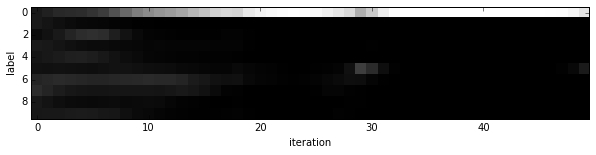

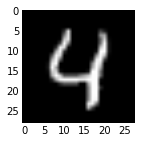

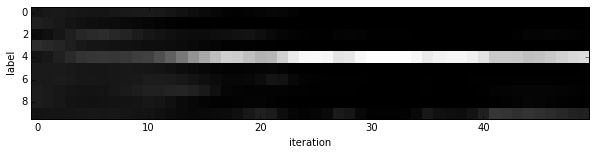

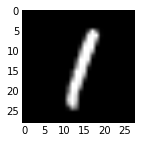

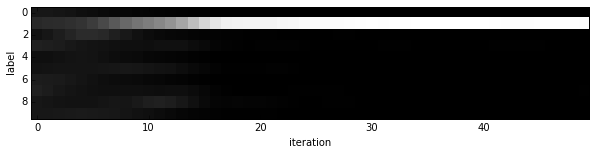

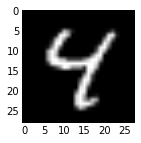

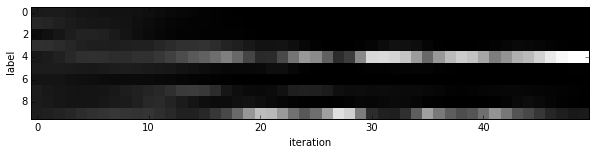

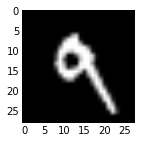

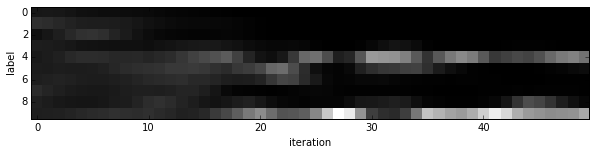

In [20]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')